# Using GANs to create art

## Description

This notebook contains the code used for the "I’m Something of a Painter Myself" Kaggle competition (link: https://www.kaggle.com/competitions/gan-getting-started/overview).

The following description of the competition is taken from the Kaggle website:

*A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.*

*The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.*

*Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.*

## Description of Dataset

The following description of the data used in the competition is taken from the Kaggle website:

*Files:*
   - *monet_jpg - 300 Monet paintings sized 256x256 in JPEG format*
   - *monet_tfrec - 300 Monet paintings sized 256x256 in TFRecord format*
   - *photo_jpg - 7028 photos sized 256x256 in JPEG format*
   - *photo_tfrec - 7028 photos sized 256x256 in TFRecord forma*
    
*The monet directories contain Monet paintings. Use these images to train your model.*

*The photo directories contain photos. Add Monet-style to these images and submit your generated jpeg images as a zip file. Other photos outside of this dataset can be transformed but keep your submission file limited to 10,000 images.*

## Import Libraries

In [1]:
# !pip install torchvision

In [2]:
import pandas as pd
import numpy as np

import os
import zipfile

from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

import torch
import torch.nn as nn
import torch.optim as optim

## Explore Data

Create class objects for image sets.

In [17]:
# Image class to load the monet and photo images
class Images(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.transform = transform
        self.img_paths = [os.path.join(img_dir, img_name) for img_name in os.listdir(img_dir)]
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img
    
    def __getimage__(self, idx):
        img_path = self.img_paths[idx]
        img = Image.open(img_path)
        display(img)

    
# Define image transformations
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
    
# Load monet data 
monet_dataset = Images(img_dir='monet_jpg/', transform=transform)
monet_dataloader = DataLoader(monet_dataset, batch_size=16, shuffle=True)

# Load photo data
photo_dataset = Images(img_dir='photo_jpg/', transform=transform)
photo_dataloader = DataLoader(photo_dataset, batch_size=16, shuffle=True)

Explore number of photos in dataset.

In [4]:
print("The number of monet images is: ", len(monet_dataset))
print("The number of photo images is: ", len(photo_dataset))

The number of monet images is:  300
The number of photo images is:  7038


Let's look at some photos.

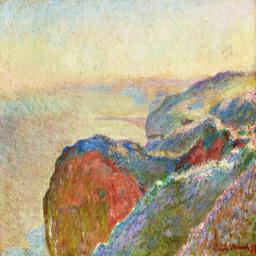

In [18]:
monet_dataset.__getimage__(0)

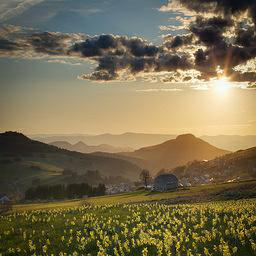

In [19]:
photo_dataset.__getimage__(0)

## Define architecture

Define generator and discriminator class objects.

In [55]:
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),
            
            self.downsample(64, 128),
            self.downsample(128, 256),
            
            self.residualblock(256),
            self.residualblock(256),
            self.residualblock(256),
            
            self.upsample(256, 128),
            self.upsample(128, 64),
            
            nn.Conv2d(64, out_channels, kernel_size=3, stride=2, padding=1),
            nn.Tanh()
        )
    
    def downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def residualblock(self, in_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),

            nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1),
            nn.InstanceNorm2d(in_channels)
        )
    
    def upsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.model(x)

    
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(512, 1, kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        return self.model(x)

Create generator and discriminator objects.

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

G_Monet = Generator(in_channels = 3, out_channels = 3)
G_Photo = Generator(in_channels = 3, out_channels = 3)
D_Monet = Discriminator(in_channels = 3)
D_Photo = Discriminator(in_channels = 3)

G_Monet.to(device)
G_Photo.to(device)
D_Monet.to(device)
D_Photo.to(device)

Discriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (4): Conv2d(512, 1, kernel_

In [58]:
# Define yperparameters
lr = 0.0001
betas = (0.5, 0.999)

# Initialize optimizers
optimizer_G = optim.Adam(list(G_Monet.parameters()) + list(G_Photo.parameters()), lr=lr, betas=betas)
optimizer_D_Monet = optim.Adam(D_Monet.parameters(), lr=lr, betas=betas)
optimizer_D_Photo = optim.Adam(D_Photo.parameters(), lr=lr, betas=betas)

## Train model

Next, let's train the model.

In [60]:
# Set parameters
epochs = 10
adv_loss = nn.MSELoss()

# Train model
for epoch in range(epochs):
    for i, (org_monet, org_photo) in enumerate(zip(monet_dataloader, photo_dataloader)):
        org_monet = org_monet.to(device)
        org_photo = org_photo.to(device)
        
        #################
        # Train generator
        #################
        
        optimizer_G.zero_grad()
        
        # Measure loss in fake monet
        fake_monet = G_Monet(org_monet)
        pred_fake_monet = D_Monet(fake_monet)
        loss_G_monet = adv_loss(pred_fake_monet, torch.ones_like(pred_fake_monet))
        
        # Measure loss in fake photo
        fake_photo = G_Photo(org_photo)
        pred_fake_photo = D_Photo(fake_photo)
        loss_G_photo = adv_loss(pred_fake_photo, torch.ones_like(pred_fake_photo))
        
        # Measure total loss
        loss_G = loss_G_monet + loss_G_photo
        
        # Backward propogation and optimization
        loss_G.backward()
        optimizer_G.step()
        
        ###########################
        # Train Discriminator Monet
        ###########################
        
        optimizer_D_Monet.zero_grad()
        
        # Measure loss in original monet
        pred_org = D_Monet(org_monet)
        loss_D_org = adv_loss(pred_org, torch.ones_like(pred_org))
        
        # Measure loss in fake monet
        pred_fake = D_Monet(fake_monet.detach())
        loss_D_fake = adv_loss(pred_fake, torch.zeros_like(pred_fake))
        
        # Measure total loss
        loss_D_Monet = (loss_D_org + loss_D_fake) / 2
        
        # Backward propogation and optimization
        loss_D_Monet.backward()
        optimizer_D_Monet.step()

        ###########################
        # Train Discriminator Photo
        ###########################
        
        optimizer_D_Photo.zero_grad()
        
        # Measure loss in original photo
        pred_org = D_Photo(org_photo)
        loss_D_org = adv_loss(pred_org, torch.ones_like(pred_org))
        
        # Measure loss in fake monet
        pred_fake = D_Photo(fake_photo.detach())
        loss_D_fake = adv_loss(pred_fake, torch.zeros_like(pred_fake))
        
        # Measure total loss
        loss_D_Photo = (loss_D_org + loss_D_fake) / 2
        
        # Backward propogation and optimization
        loss_D_Photo.backward()
        optimizer_D_Photo.step()

    # Print loss at end of each epoch
    print(f"Epoch [{epoch + 1}/{epochs}] | Generator loss: {loss_G.item():.4f} | Discriminator (Monet) loss:"
      f" {loss_D_Monet.item():.4f} | Discriminator (Photo) loss: {loss_D_Photo.item():.4f}")

Epoch [1/10] | Generator loss: 1.6090 | Discriminator (Monet) loss: 0.0961 | Discriminator (Photo) loss: 0.0826
Epoch [2/10] | Generator loss: 1.9963 | Discriminator (Monet) loss: 0.0768 | Discriminator (Photo) loss: 0.0563
Epoch [3/10] | Generator loss: 2.0973 | Discriminator (Monet) loss: 0.0379 | Discriminator (Photo) loss: 0.0435
Epoch [4/10] | Generator loss: 1.8967 | Discriminator (Monet) loss: 0.0280 | Discriminator (Photo) loss: 0.0358
Epoch [5/10] | Generator loss: 2.0542 | Discriminator (Monet) loss: 0.0300 | Discriminator (Photo) loss: 0.0375
Epoch [6/10] | Generator loss: 2.0252 | Discriminator (Monet) loss: 0.0224 | Discriminator (Photo) loss: 0.0546
Epoch [7/10] | Generator loss: 2.0840 | Discriminator (Monet) loss: 0.0250 | Discriminator (Photo) loss: 0.1146
Epoch [8/10] | Generator loss: 1.8772 | Discriminator (Monet) loss: 0.0179 | Discriminator (Photo) loss: 0.0220
Epoch [9/10] | Generator loss: 1.9845 | Discriminator (Monet) loss: 0.0383 | Discriminator (Photo) loss:

## Apply model

Let's export the images created by the model.

In [73]:
# Define output directory
output_dir = 'output'

# Generate images and save
G_Monet.eval()
img_count = 0
for i, org_photo in enumerate(photo_dataloader):
    
    org_photo = org_photo.to(device)
    
    with torch.no_grad():
        fake_monet_batch = G_Monet(org_photo)
    
    for k, fake_monet in enumerate(fake_monet_batch):
        
        # torch.Size([3, 32, 32])
        
        fake_monet = fake_monet.permute(1, 2, 0)
        fake_monet = fake_monet.cpu().numpy()
        fake_monet = (fake_monet * 0.5 + 0.5) * 255
        fake_monet = np.clip(fake_monet, 0, 255).astype(np.uint8)  # Ensure valid pixel values
        
        img = Image.fromarray(fake_monet)
        img_path = os.path.join(output_dir, f'image_{img_count + 1}.png')
        img.save(img_path)
        img_count += 1

In [76]:
# Zip files
zip_filename = "images.zip"
with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as img_zip:
    for filename in os.listdir(output_dir):
        img_zip.write(os.path.join(output_dir, filename), arcname=filename)

## Parameter/Hyperparameter Tuning

There are many parameters/hyperparameters that can be tuned to optimize model performance:
- Epochs: Increasing the number of epochs may improve model performance
- Learning Rate: Tuning the learning rate may lead to faster model training
- Number of layers/neurons: Increasing the number of layers and neurons can help the model learn more complex associations
- Loss function: The use of different types of loss functions can influence the backward propogation step
- Optimizer: The optimizer used can influence model training

To increase the readability of the notebook, we have tested these parameter settings seperately.

## Conclusion

In this project, we used GAN to take photos and generate new photos in the style of Monet. Model building was performed using packages contained in the torch library.